## Object detection Examples

### D-FINE

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


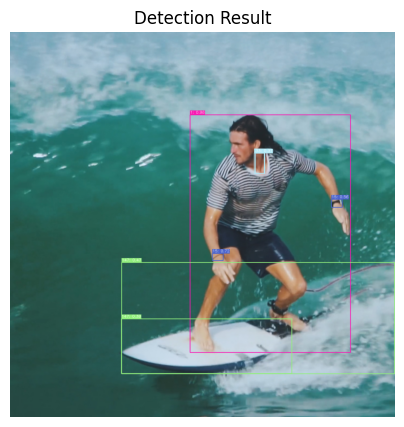

In [1]:
from ezonnx import DFINE,visualize_images
det = DFINE("s")  # you can choose "s", "m", "l", "x"
ret = det("images/surf.jpg")
visualize_images("Detection Result",ret.visualized_img)

### RTMDet

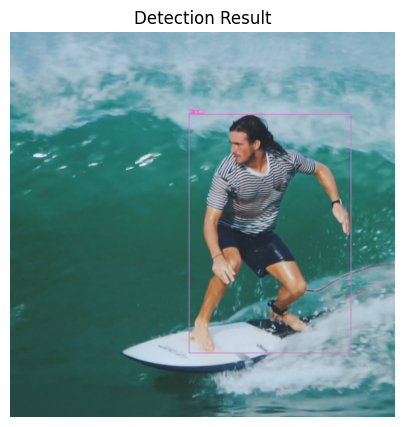

In [2]:
from ezonnx import RTMDet,visualize_images
det = RTMDet("m-person")  # you can choose "n-person","m-person","n-hand","tiny-coco","s-coco","m-coco","l-coco","x-coco")
ret = det("images/surf.jpg")
visualize_images("Detection Result",ret.visualized_img)

### DWPose - person whole body keypoint detection

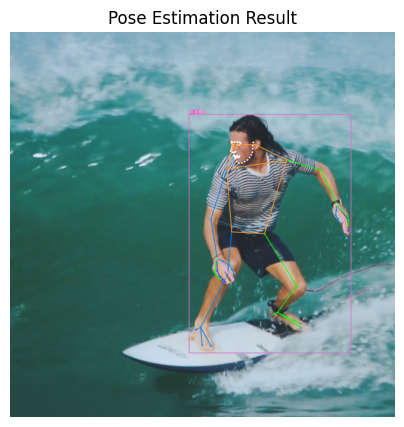

In [3]:
from ezonnx import DWPose,visualize_images
pose = DWPose() # default detector is RTMDet
result = pose("images/surf.jpg")
visualize_images("Pose Estimation Result",result.visualized_img)